# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

In [99]:
# For Google Colab / local machine
import tensorflow.keras
ver = tensorflow.version.VERSION

if float(ver[:3]) > 2.7:
  print("Latest TensorFlow version detected -> Prepare Google Colab usage\n")
  google_colab = 1
  from google.colab import drive
  drive.mount('/content/drive/')
  colab_path = "/content/drive/MyDrive/Masterarbeit/Code/two-hearts/"
  import sys
  sys.path.append(colab_path)
else:
  colab_path = ""

In [100]:
# Import libraries
import os
import datetime
import random
import pickle
import IPython
import IPython.display
import numpy as np
from numpy import array, hstack
import pandas as pd
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'Arial'
import seaborn as sns
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

from lists import dyads, num_dyads, participants, num_participants

print("TensorFlow version:",tensorflow.version.VERSION)

TensorFlow version: 2.6.0


## Deep Learning

In [101]:
# Load all results
with open('model/data_all.pickle', 'rb') as handle: # alternative: pd.read_pickle
    data_all = pickle.load(handle)

In [102]:
# Set sampling rate
sampling_rate = 50
print("Sampling rate:", sampling_rate)

# Set number of time steps
n_steps_in, n_steps_out = 5*sampling_rate, 2*sampling_rate
print("Time steps:", n_steps_in, n_steps_out)

# Set conditions
condition = ["sit","gaze","gaze_swap"]
print("Conditions:", condition)

# Show number of participants 
print("Participants:", num_participants)

# Show number of dyads
print("Dyads:", num_dyads)

# Show number of trials
trial = list(data_all.keys())
print("Number of training trials:",len(trial))

Sampling rate: 50
Time steps: 250 100
Conditions: ['sit', 'gaze', 'gaze_swap']
Participants: 8
Dyads: 4
Number of training trials: 3


### Summary

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 2)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 100), (None, 41200       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100)          400         lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 100, 100)     0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

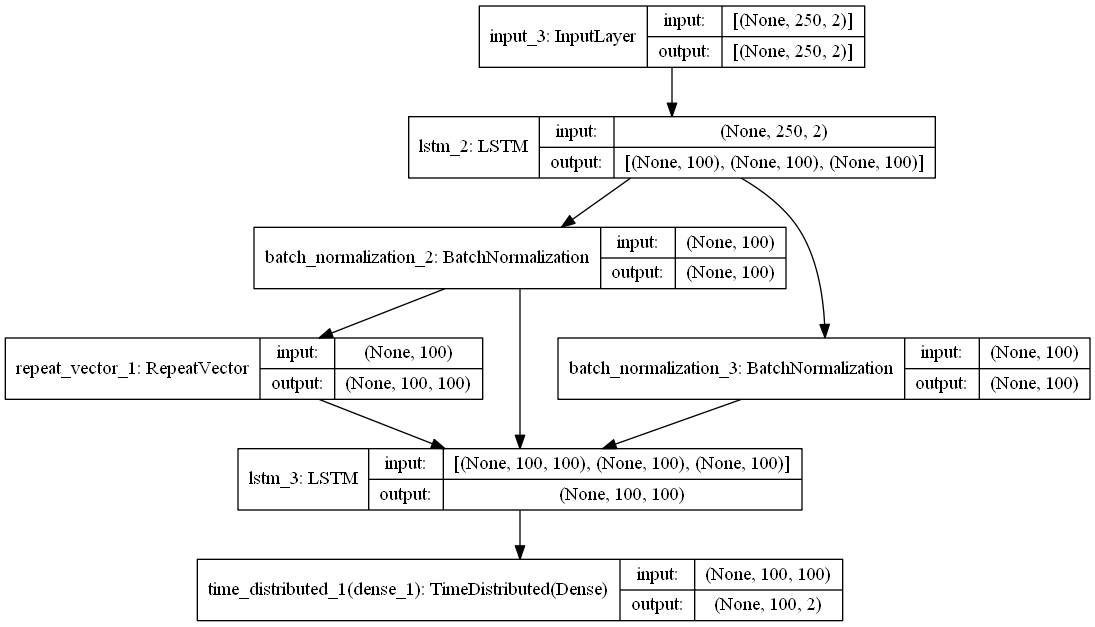

In [103]:
model = load_model(data_all["01"]["model_all"]["gaze"]) # install nomkl if kernel dies here because of kmp duplicate library
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='plots/keras_model_plot.png')

Number of participants: 8
Number of dyads: 4
num_train_samples per dyad: 174
num_vali_samples per dyad: 58
num_test_samples per dyad: 58
Length of samples for each set: 696 232 232


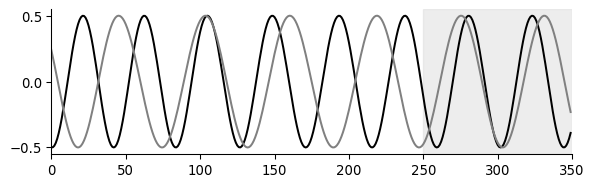

In [104]:
samples = data_all["01"]["samples_all"]["gaze"]

num_participants = len(participants)
num_dyads = len(dyads)

len(samples["X_input_train"])
len(samples["y_output_train"])
len(samples["X_input_train"])

print("Number of participants:", num_participants)
print("Number of dyads:", num_dyads)
print("num_train_samples per dyad:", len(samples["X_input_train"])//num_dyads)
print("num_vali_samples per dyad:", len(samples["X_input_vali"])//num_dyads)
print("num_test_samples per dyad:", len(samples["X_input_test"])//num_dyads)
print("Length of samples for each set:", len(samples["X_input_train"]),len(samples["X_input_vali"]),len(samples["X_input_test"]))

# Plot data
fig = plt.figure(figsize=(7,2), dpi=96)
sample_example = [np.append(samples["X_input_train"][14,:,0], samples["y_output_train"][14,:,0]),np.append(samples["X_input_train"][14,:,1], samples["y_output_train"][14,:,1])]
plt.plot(sample_example[0], color="k", label = "Frau")
plt.plot(sample_example[1], color="grey", label = "Mann")
plt.margins(x=0)
plt.yticks([0.5,0,-0.5])
plt.axvspan(250,350, color='gainsboro', alpha=0.5)

sns.despine()

plt.savefig("plots/sample.png", dpi=512)

### Evaluation

In [232]:
# Show saved evaluations
print("Metrics for all trials")

for x in trial: print(data_all[x]["results_all"])

# Calculate means ans stds for both metrics
# MSE
mse_temp = []
mse_all = []
for i,x in enumerate(trial):
    for y in condition:
        mse_temp.append(data_all[x]["results_all"][y][0])
    mse_all.append(mse_temp)
    mse_temp = []

# MAE
mae_temp = []
mae_all = []
for i,x in enumerate(trial):
    for y in condition:
        mae_temp.append(data_all[x]["results_all"][y][1])
    mae_all.append(mae_temp)
    mae_temp = []


# Means
print("\nMeans")

losses_mean = pd.DataFrame(
    {"sit": [np.mean(np.array(mse_all)[:,0]), np.mean(np.array(mae_all)[:,0])],
     "gaze": [np.mean(np.array(mse_all)[:,1]), np.mean(np.array(mae_all)[:,1])],
     "gaze_swap": [np.mean(np.array(mse_all)[:,2]), np.mean(np.array(mae_all)[:,2])]},
      index=(["MSE", "MAE"]))

print(losses_mean.T)

# STDs
print("\nSDs")

losses_std = pd.DataFrame(
    {"sit": [np.std(np.array(mse_all)[:,0]), np.std(np.array(mae_all)[:,0])],
     "gaze": [np.std(np.array(mse_all)[:,1]), np.std(np.array(mae_all)[:,1])],
     "gaze_swap": [np.std(np.array(mse_all)[:,2]), np.std(np.array(mae_all)[:,2])]},
      index=(["MSE", "MAE"]))

print(losses_std.T)

Metrics for all trials
{'sit': [0.03460807725787163, 0.13051778078079224], 'gaze': [0.031109962612390518, 0.12224014103412628], 'gaze_swap': [0.029515661299228668, 0.11616434156894684]}
{'sit': [0.03360592946410179, 0.12561793625354767], 'gaze': [0.03333088755607605, 0.12640951573848724], 'gaze_swap': [0.031162746250629425, 0.11986301094293594]}
{'sit': [0.0328359380364418, 0.12651871144771576], 'gaze': [0.029603369534015656, 0.11635152995586395], 'gaze_swap': [0.03152765333652496, 0.12159320712089539]}

Means
                MSE       MAE
sit        0.033683  0.127551
gaze       0.031348  0.121667
gaze_swap  0.030735  0.119207

SDs
                MSE       MAE
sit        0.000726  0.002129
gaze       0.001531  0.004126
gaze_swap  0.000875  0.002264


In [106]:
# Sanity check
results_check = model.evaluate(samples["X_input_test"], samples["y_output_test"], batch_size=64, verbose=0)
print(results_check)
print(data_all["01"]["results_all"]["gaze"]) # compare with saved results from 02_model

[0.031109964475035667, 0.12224014103412628]
[0.031109962612390518, 0.12224014103412628]


### Training epochs

In [107]:
# Show training length in dataframe
 
# Prepare nested list
training_length_list = []
for i in trial: 
    k = 0
    temp = []
    for j in list(data_all[x]["history_all"].keys()):
        k = k+1
        temp.append(len(data_all[i]["history_all"][j]["loss"]))
    training_length_list.append(temp)
# Save nested list as dictionary
training_length_dict = {}
for i in range(len(training_length_list)):
    training_length_dict[f"Trial {i}"] = training_length_list[i]
# Transform dictionary into dataframe
training_length = pd.DataFrame.from_dict(training_length_dict, orient='index', columns=[list(data_all[x]["history_all"].keys())])
training_length = training_length-50 # patience = 50

print("Training epochs:")
print(training_length)

training_length_info = pd.DataFrame(
    {"sit":  [training_length.mean(axis=0)[0], training_length.std(axis=0)[0], training_length.min(axis=0)[0], training_length.max(axis=0)[0]],
     "gaze": [training_length.mean(axis=0)[1], training_length.std(axis=0)[1], training_length.min(axis=0)[1], training_length.max(axis=0)[1]],
     "gaze_swap": [training_length.mean(axis=0)[2], training_length.std(axis=0)[2], training_length.min(axis=0)[2], training_length.max(axis=0)[2]]},
     index = (["Mean", "SD", "Min", "Max"]))

training_length_info = training_length_info.round(2)
print("\nTraining info:")
print(training_length_info)

Training epochs:
         sit gaze gaze_swap
Trial 0  133  217       181
Trial 1  181  130       245
Trial 2  165  249       209

Training info:
         sit    gaze  gaze_swap
Mean  159.67  198.67     211.67
SD     24.44   61.58      32.08
Min   133.00  130.00     181.00
Max   181.00  249.00     245.00


In [108]:
print("Mean training length: ",training_length.mean().mean())

Mean training length:  190.0


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


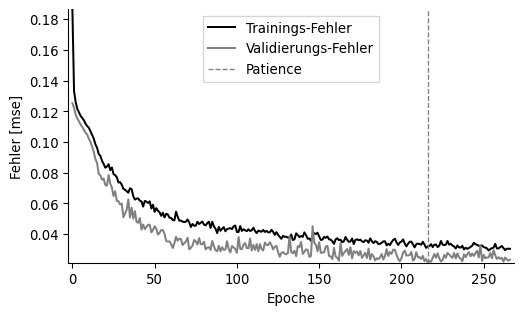

In [109]:
# Plot training loss
history = data_all["01"]["history_all"]["gaze"]
print(history.keys())
train_loss = history['loss']
valid_loss = history['val_loss']

fig = plt.figure(figsize=(6,3.5), dpi=96)

# plt.title('Training- vs. Validation-Loss (mse)')
plt.ylabel('Fehler [mse]')
plt.xlabel('Epoche')
# plt.ylim(ymax = 0.2)
plt.margins(y=0,x=0.01)

plt.plot(train_loss, label='Trainings-Fehler', color="k"), 
plt.plot(valid_loss, label='Validierungs-Fehler', color="grey")

plt.vlines(x=(len(train_loss)-51),ymin=min(valid_loss), ymax=max(train_loss), colors='grey', ls='--', lw=1, label='Patience')
plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=1) #bbox_to_anchor=(0.5, -0.15)
sns.despine()

plt.savefig("plots/training_loss.png", dpi=512)

### Visualisation

In [167]:
# Make predictions based on sample data
yhat_output_train = model.predict(samples["X_input_train"],batch_size=10)
yhat_output_test = model.predict(samples["X_input_test"],batch_size=10)
print(yhat_output_train.shape, yhat_output_test.shape)
print(samples["y_output_train"].shape, samples["y_output_test"].shape)

(696, 100, 2) (232, 100, 2)
(696, 100, 2) (232, 100, 2)


In [ ]:
def data_dyad_plot(ee):
    train = np.append(samples["X_input_train"][sample_no,:,person],samples["y_output_train"][sample_no,:,person])
    train_hat = np.append(np.full([len(samples["X_input_train"][sample_no,:,person])], np.nan),yhat_output_train[sample_no,:,person]) # add 250 nans at start
    return train, train_hat

In [233]:
# Graphical demonstration

sample_no = [1,2,3]
person = 0
train = []
train_hat = []

for i in sample_no:
    train.append(np.append(samples["X_input_train"][sample_no,:,person],samples["y_output_train"][sample_no,:,person]))
    train_hat.append(np.append(np.full([len(samples["X_input_train"][sample_no,:,person])], np.nan),yhat_output_train[sample_no,:,person])) # add 250 nans at start



# fig = plt.figure(figsize=(6,2), dpi=96)
# plt.figure(1)
# plt.plot(train, label="Ground Truth", color="k")
# plt.plot(train_hat, label="Projektion", color="grey")

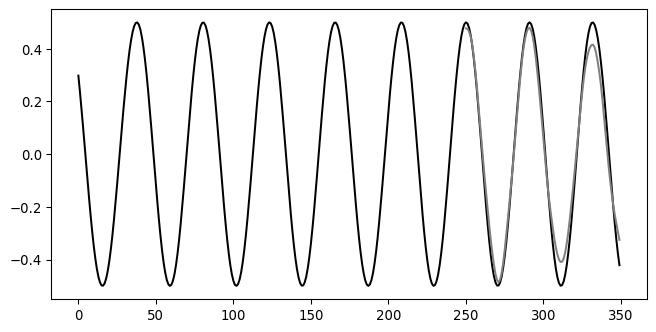

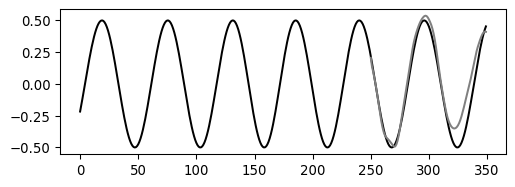

In [113]:
# Graphical demonstration
sample_no = 18
person = 0

# Demonstrate training
# Person 1
train_hat = np.append(np.full([len(samples["X_input_train"][sample_no,:,person])], np.nan),yhat_output_train[sample_no,:,person]) # add 250 nans at start
train = np.append(samples["X_input_train"][sample_no,:,person],samples["y_output_train"][sample_no,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(1)
plt.plot(train, label="Ground Truth", color="k")
plt.plot(train_hat, label="Projektion", color="grey")

# Person 2
train_hat = np.append(np.full([len(samples["X_input_train"][sample_no,:,person+1])], np.nan),yhat_output_train[sample_no,:,person+1]) # add 250 nan at start
train = np.append(samples["X_input_train"][sample_no,:,person+1],samples["y_output_train"][sample_no,:,person+1])

fig = plt.figure(figsize=(6,2), dpi=96)
plt.figure(2)
plt.plot(train, label="Ground Truth", color="k")
plt.plot(train_hat, label="Projektion", color="grey")

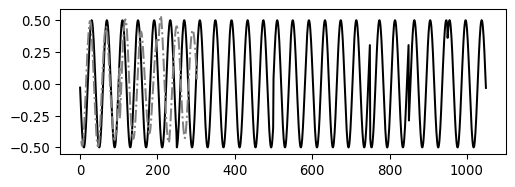

In [234]:
# Demonstrate prediction

test_hat = np.append(np.full([len(samples["X_input_test"][sample_no,:,person])], np.nan),yhat_output_test[sample_no,:,person]) # add 250 nan at start
test = np.append(samples["X_input_test"][sample_no,:,person],samples["y_output_test"][sample_no,:,person])

fig = plt.figure(figsize=(6,2), dpi=96)
plt.figure(1)
plt.plot(test, label="Ground Truth", color="k")
plt.plot(test_hat, label="Projektion", color="grey", ls="-.")

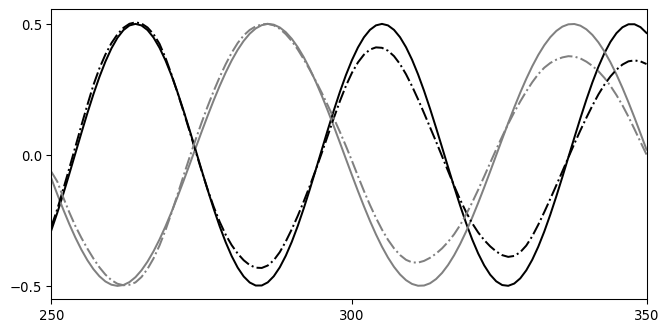

In [235]:
sample_no = 2
fig = plt.figure(figsize=(8,4), dpi=96)
plt.plot(samples["y_output_test"][sample_no,:,0], color="black")
plt.plot(samples["y_output_test"][sample_no,:,1], color="grey")
plt.plot(yhat_output_test[sample_no,:,0], color="black", ls="-.")
plt.plot(yhat_output_test[sample_no,:,1], color="grey", ls="-.")
plt.xticks([0,50,99],[250,300,350])
plt.yticks([-0.5,0,0.5])
plt.margins(x=0)
# sns.despine()

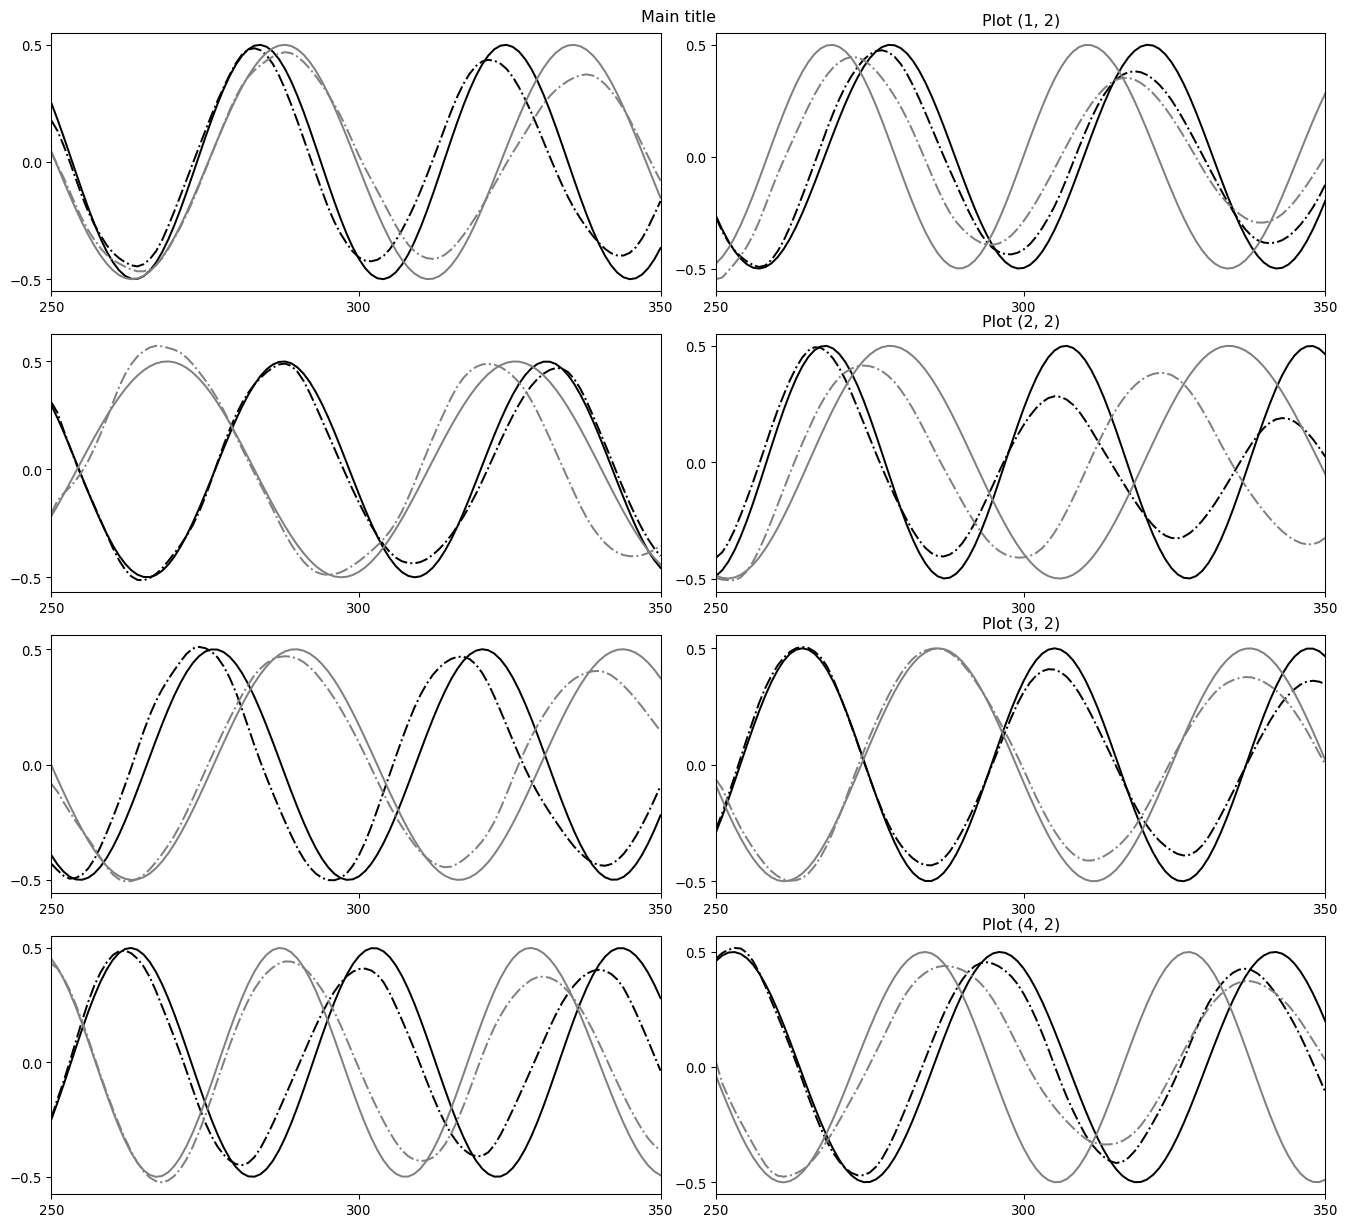

In [236]:
sample_no = [30,13,2,50]

n_rows = len(sample_no)
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols,figsize=(14,13), dpi=96)
fig.suptitle('Main title')
fig.tight_layout()

for row_num in range(n_rows):
    for col_num in range(n_cols):
        if col_num == 0:
            ax = axes[row_num][col_num]
            ax.plot(samples["y_output_train"][sample_no[row_num],:,0], color="black")
            ax.plot(yhat_output_train[sample_no[row_num],:,0], color="black", ls="-.")
            ax.plot(samples["y_output_train"][sample_no[row_num],:,1], color="grey")
            ax.plot(yhat_output_train[sample_no[row_num],:,1], color="grey", ls="-.")
            ax.set_xticks([0,50,99])
            ax.set_xticklabels([250,300,350])
            ax.set_yticks([-0.5,0,0.5])
            ax.margins(x=0)
        elif col_num == 1:
            ax = axes[row_num][col_num]
            ax.plot(samples["y_output_test"][sample_no[row_num],:,0], color="black")
            ax.plot(yhat_output_test[sample_no[row_num],:,0], color="black", ls="-.")
            ax.plot(samples["y_output_test"][sample_no[row_num],:,1], color="grey")
            ax.plot(yhat_output_test[sample_no[row_num],:,1], color="grey", ls="-.")
            ax.set_title(f'Plot ({row_num+1}, {col_num+1})')
            ax.set_xticks([0,50,99])
            ax.set_xticklabels([250,300,350])
            ax.set_yticks([-0.5,0,0.5])
            ax.margins(x=0)
# sns.despine()

plt.show()

### Data Distribution

In [ ]:
data_final = {
  "train_pred": yhat_output_train,
  "train_true": samples["y_output_train"],
  "test_pred": yhat_output_test,
  "test_true": samples["y_output_test"]
}

data_final_keys = list(data_final.keys())
data_final_keys

['train_pred', 'train_true', 'test_pred', 'test_true']

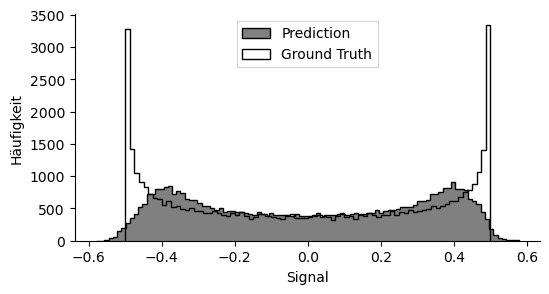

In [ ]:
# Plot value distribution
# test data
plt.figure(figsize=(6, 3), dpi=100)

# plt.title('value distribution: '+lb)
plt.xlabel('Signal')
plt.ylabel('Häufigkeit')

plt.hist(data_final['test_pred'].flatten(), label='Prediction', bins=100, histtype='step', edgecolor='black', fill=True, color='grey')
plt.hist(data_final['test_true'].flatten(), label='Ground Truth', bins=80, histtype='step', edgecolor='black', fill=False)
plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=1) #bbox_to_anchor=(0.5, -0.15)

sns.despine()
plt.show()

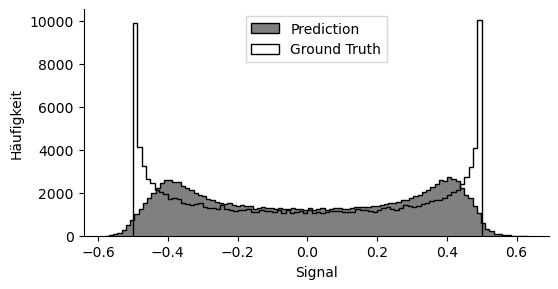

In [ ]:
# Plot value distribution
# train data
plt.figure(figsize=(6, 3), dpi=100)

plt.xlabel('Signal')
plt.ylabel('Häufigkeit')

plt.hist(data_final['train_pred'].flatten(), label='Prediction', bins=100, histtype='step', edgecolor='black', fill=True, color='grey')
plt.hist(data_final['train_true'].flatten(), label='Ground Truth', bins=80, histtype='step', edgecolor='black', fill=False)
plt.legend(loc='upper center', fancybox=False, shadow=False, ncol=1) #bbox_to_anchor=(0.5, -0.15)

sns.despine()
plt.show()

### Miscellaneous
Code from:
https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

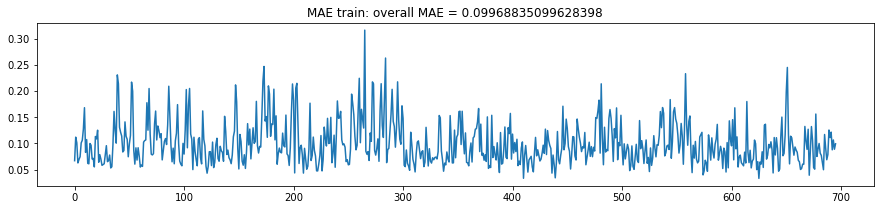

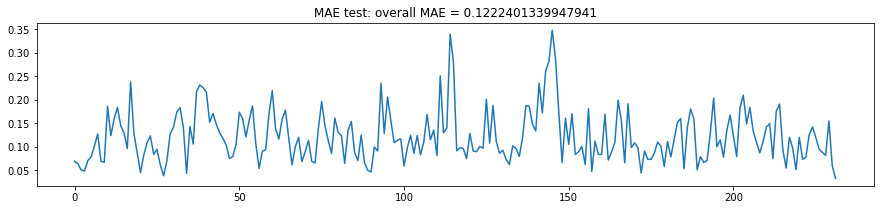

In [ ]:
# plot MAE of all samples in time order, to see if there is clear pattern (which means more training is needed)
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

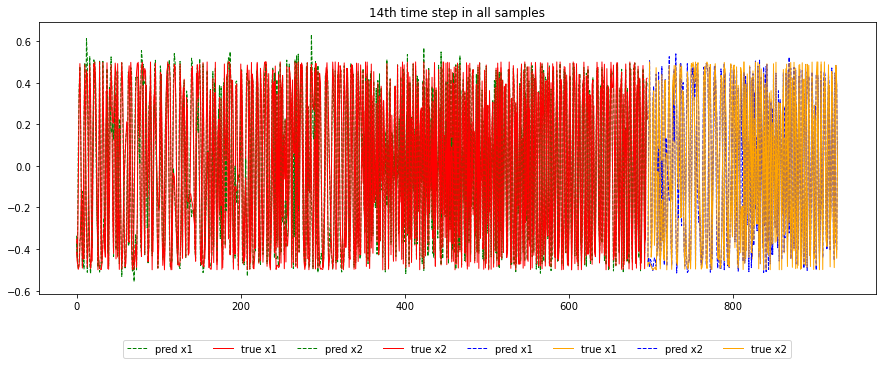

In [ ]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

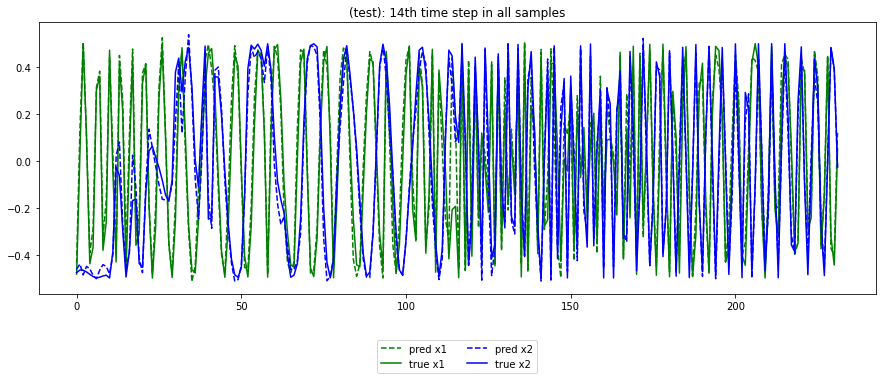

In [ ]:
# Check the nth prediction of each time step
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()